In [1]:
import scPAFA
import scanpy as sc
import json
import pandas as pd
import numpy as np
import pickle

In [2]:
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42

In [4]:
#read_adata
adata = sc.read_h5ad('../lupus/20240102_lupus_geneover30_useformultigroup.h5ad')

In [5]:
sample_meta = adata.obs[['pseudobulk_sample','donor_id','self_reported_ethnicity','disease','disease_state','Processing_Cohort','sex','batch']]
sample_meta = sample_meta.drop_duplicates(subset='pseudobulk_sample')
sample_meta.index = sample_meta['pseudobulk_sample']

In [6]:
sample_meta['batch'].value_counts()

batch
batch1             142
batch3              64
batch2              44
special_testset     32
Name: count, dtype: int64

In [7]:
sample_meta_use = sample_meta[sample_meta['batch'].isin(['batch1','batch2','batch3'])]

In [8]:
from sklearn.model_selection import train_test_split
sample_train,sample_test = train_test_split(np.array(sample_meta_use.index),test_size=0.3, random_state=2024)
print(len(sample_train))
print(len(sample_test))

175
75


In [9]:
pd.Series(sample_train).to_csv('../lupus/20240102_sample_train.csv')
pd.Series(sample_test).to_csv('../lupus/20240102_sample_test.csv')

In [9]:
sample_meta_train = sample_meta.loc[sample_train].copy()
sample_meta_test = sample_meta.loc[sample_test].copy()

In [10]:
sample_meta_train['disease'].value_counts()

disease
SLE       124
normal     51
Name: count, dtype: int64

In [11]:
sample_meta_test['disease'].value_counts()

disease
SLE       58
normal    17
Name: count, dtype: int64

In [12]:
pd.crosstab(sample_meta_train['batch'],sample_meta_train['disease'])

disease,SLE,normal
batch,,
batch1,86,18
batch2,18,14
batch3,20,19


In [13]:
pd.crosstab(sample_meta_test['batch'],sample_meta_test['disease'])

disease,SLE,normal
batch,,
batch1,34,4
batch2,9,3
batch3,15,10


In [13]:
adata_train = adata[adata.obs['pseudobulk_sample'].isin(sample_train)]
adata_train.write_h5ad('../lupus/data_for_machine_learning/20240103_lupus_sample_train_175.h5ad')

In [14]:
adata_train = sc.read_h5ad('../lupus/data_for_machine_learning/20240103_lupus_sample_train_175.h5ad')

In [14]:
adata_train.obs['pseudobulk_sample'].value_counts()

pseudobulk_sample
4.0_HC-009_normal_na         9955
3.0_HC-502_normal_na         7651
2.0_1262_SLE_managed         7470
2.0_1279_SLE_managed         7467
4.0_1325_SLE_managed         7402
                             ... 
3.0_FLARE010_SLE_treated     1491
4.0_ICC_control_normal_na    1487
2.0_IGTB1539_normal_na       1440
3.0_1586_SLE_treated         1065
3.0_FLARE010_SLE_flare        761
Name: count, Length: 175, dtype: int64

In [15]:
adata_train.shape

(664214, 20514)

In [14]:
adata_test = adata[adata.obs['pseudobulk_sample'].isin(sample_test)]
adata_test.write_h5ad('../lupus/data_for_machine_learning/20240103_lupus_sample_test_75.h5ad')

In [16]:
sample_meta_train['batch'] = sample_meta_train['batch'].astype(str).astype("category")

In [18]:
sample_meta_train.to_csv('./lupus_data_reverse/20241105_lupus_sample_metadata.csv')

In [16]:
Ucell_result = pd.read_parquet('/data/scPAFA_paper/lupus_file/20231115_Ucell_lupus_bioplanet.parquet')
Ucell_result = Ucell_result.loc[adata_train.obs.index]

In [30]:
?scPAFA.pb.generate_scpafa_input_multigroup

In [17]:
pseudobulk_table = scPAFA.pb.generate_scpafa_input_multigroup(metadata=adata_train.obs,
                                                    PAS_dataframe=Ucell_result,
                                                    min_cell_number_per_sample=25,
                                                    min_percentage_sample_per_view=0.75,
                                                    sample_column='pseudobulk_sample',
                                                    view_column='author_cell_type',
                                                    group_column='batch',
                                                    top_percentage=0.25)

3 groups indentified
processing group batch1
Select the top 346 pathways with the maximum variance
Done_Qc
Done_matrix
Done_longtable
processing group batch3
Select the top 346 pathways with the maximum variance
Done_Qc
Done_matrix
Done_longtable
processing group batch2
Select the top 346 pathways with the maximum variance
Done_Qc
Done_matrix
Done_longtable


In [18]:
MOFA_model = scPAFA.pb.run_mofapy2(long_table=pseudobulk_table,
                                   scale_groups=True,
                                   scale_views=True,
                                   factor_number=10,
                                   random_seed=2023,
                                   spikeslab_weights=True,
                                   ard_factors = True,
                                   ard_weights=True,
                                   dropR2=0.01,
                                   convergence_mode='fast')


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\scPAFA        ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

Scaling groups to unit variance...



Loaded group='batch1' view='B' with N=101 samples and D=346 features...
Loaded group='batch1' view='NK' with N=100 samples and D=346 features...
Loaded group='batch1' view='T4' with N=104 samples and D=346 features...
Loaded group='batch1' view='T8' with N=104 samples and D=346 features...
Loaded group='bat

Iteration 66: time=0.23, ELBO=-234666.91, deltaELBO=25.084 (0.00082829%), Factors=8
Iteration 67: time=0.23, ELBO=-234643.29, deltaELBO=23.623 (0.00078005%), Factors=8
Iteration 68: time=0.26, ELBO=-234620.98, deltaELBO=22.308 (0.00073664%), Factors=8
Iteration 69: time=0.24, ELBO=-234599.85, deltaELBO=21.134 (0.00069788%), Factors=8
Iteration 70: time=0.23, ELBO=-234579.71, deltaELBO=20.134 (0.00066483%), Factors=8
Iteration 71: time=0.33, ELBO=-234560.47, deltaELBO=19.248 (0.00063559%), Factors=8
Iteration 72: time=0.29, ELBO=-234542.07, deltaELBO=18.400 (0.00060759%), Factors=8
Iteration 73: time=0.25, ELBO=-234524.42, deltaELBO=17.650 (0.00058282%), Factors=8
Iteration 74: time=0.27, ELBO=-234507.35, deltaELBO=17.071 (0.00056369%), Factors=8
Iteration 75: time=0.23, ELBO=-234490.72, deltaELBO=16.626 (0.00054900%), Factors=8
Iteration 76: time=0.26, ELBO=-234474.60, deltaELBO=16.124 (0.00053243%), Factors=8
Iteration 77: time=0.25, ELBO=-234459.01, deltaELBO=15.582 (0.00051454%), Fa

In [19]:
MOFA_model.save('../lupus/mofa_model_lupus/20240102_lupus_mofa_multigroup.hdf5')

Saving model in ../lupus/mofa_model_lupus/20240102_lupus_mofa_multigroup.hdf5...


In [18]:
import mofax as mfx
MOFA_model = mfx.mofa_model('../lupus/mofa_model_lupus/20240102_lupus_mofa_multigroup.hdf5')

In [19]:
factor_matrix = pd.concat(MOFA_model.get_factors(df=True,concatenate_groups =False,scale=True))

In [9]:
MOFA_model.get_r2().to_csv('./lupus_data_reverse/lupus_model_r2.csv')

In [20]:
MOFA_model.get_views()

['B', 'NK', 'T4', 'T8', 'cDC', 'cM', 'ncM']

In [11]:
view_list = MOFA_model.get_weights(factors=['Factor1','Factor6'],concatenate_views =False,scale=True,df =True)

with open("./lupus_data_reverse/lupus_model_view_weight_list.pkl", 'wb') as file:
    pickle.dump(view_list, file)

In [21]:
sample_meta_train = sample_meta_train.loc[factor_matrix.index]

In [22]:
a1 = scPAFA.pl.runumap_and_plot(sample_factor_df=factor_matrix,metadata=sample_meta_train,label_column='disease'
                              ,width=6,height=5,random_state=2024,point_size=3,color_mapping={"SLE":"#4b91c3","normal":"#9ecad2"})

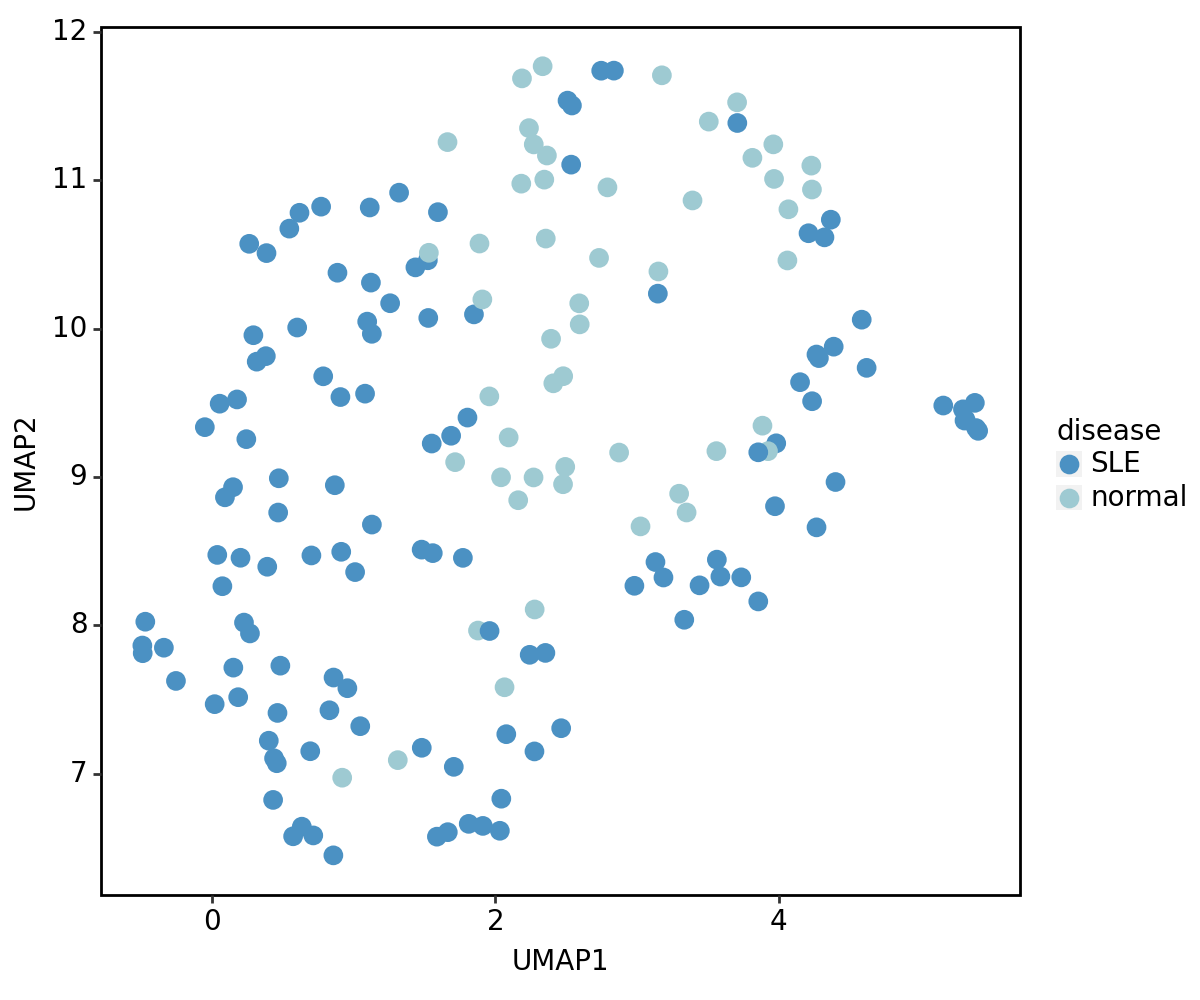

<Figure Size: (600 x 500)>

In [23]:
a1

In [25]:
a1.save('../lupus/figure_lupus/20240103_lupus_umap_disease.pdf',bbox_inches = "tight")

In [24]:
a1 = scPAFA.pl.runumap_and_plot(sample_factor_df=factor_matrix,metadata=sample_meta_train,label_column='batch'
                                ,width=6,height=5,random_state=2024,point_size=3,color_mapping={"batch1":"#1e9d76","batch2":"#67a621","batch3":"#838383"})

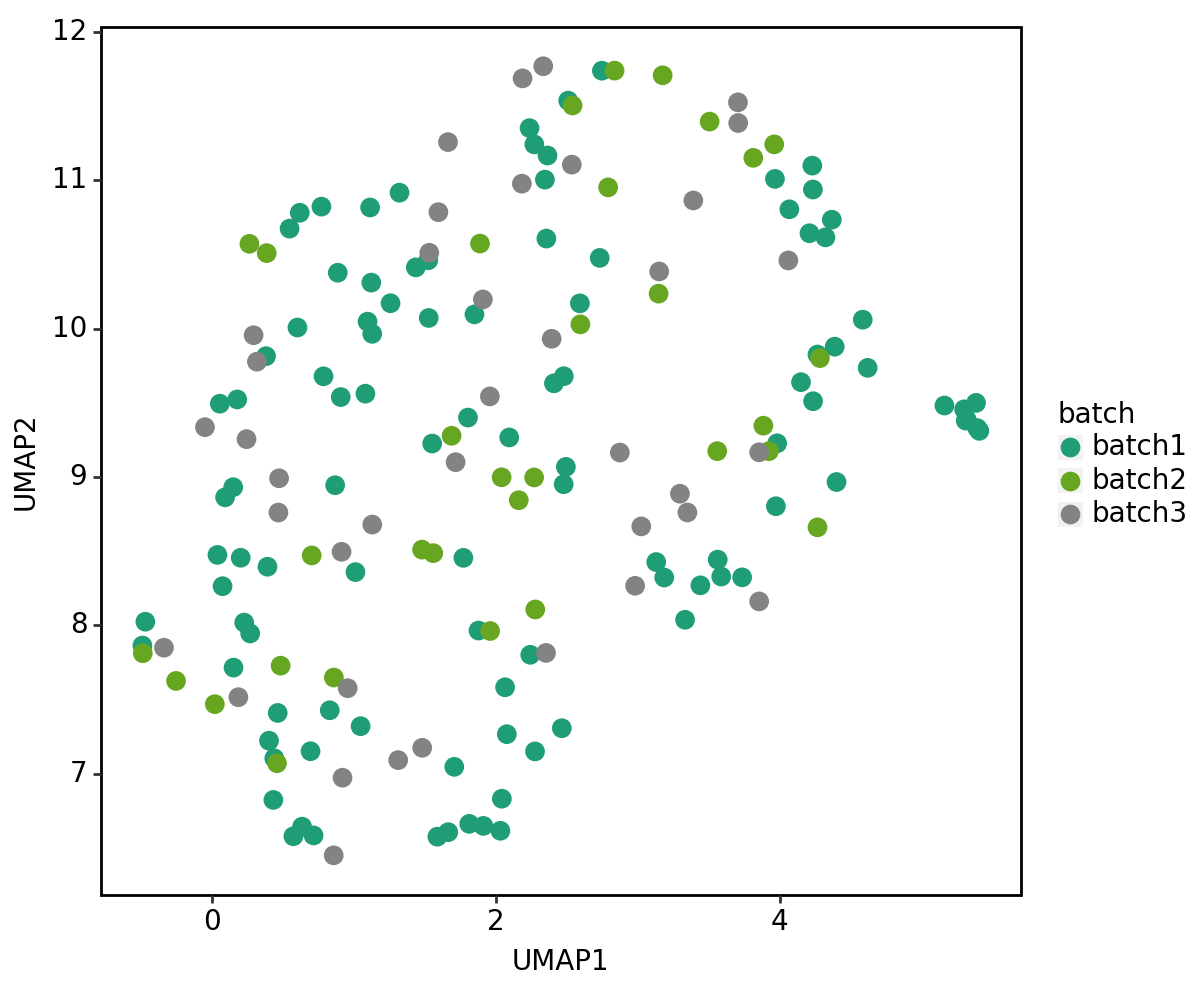

<Figure Size: (600 x 500)>

In [25]:
a1

In [28]:
a1.save('../lupus/figure_lupus/20240103_lupus_umap_batch.pdf',bbox_inches = "tight")

In [26]:
a1 = scPAFA.pl.plot_factor_scatter_2D(sample_factor_df=factor_matrix,factor_x='Factor1',factor_y='Factor6',metadata=sample_meta_train,label_column='disease'
                                ,width=6,height=5,point_size=3,color_mapping={"SLE":"#4b91c3","normal":"#9ecad2"})

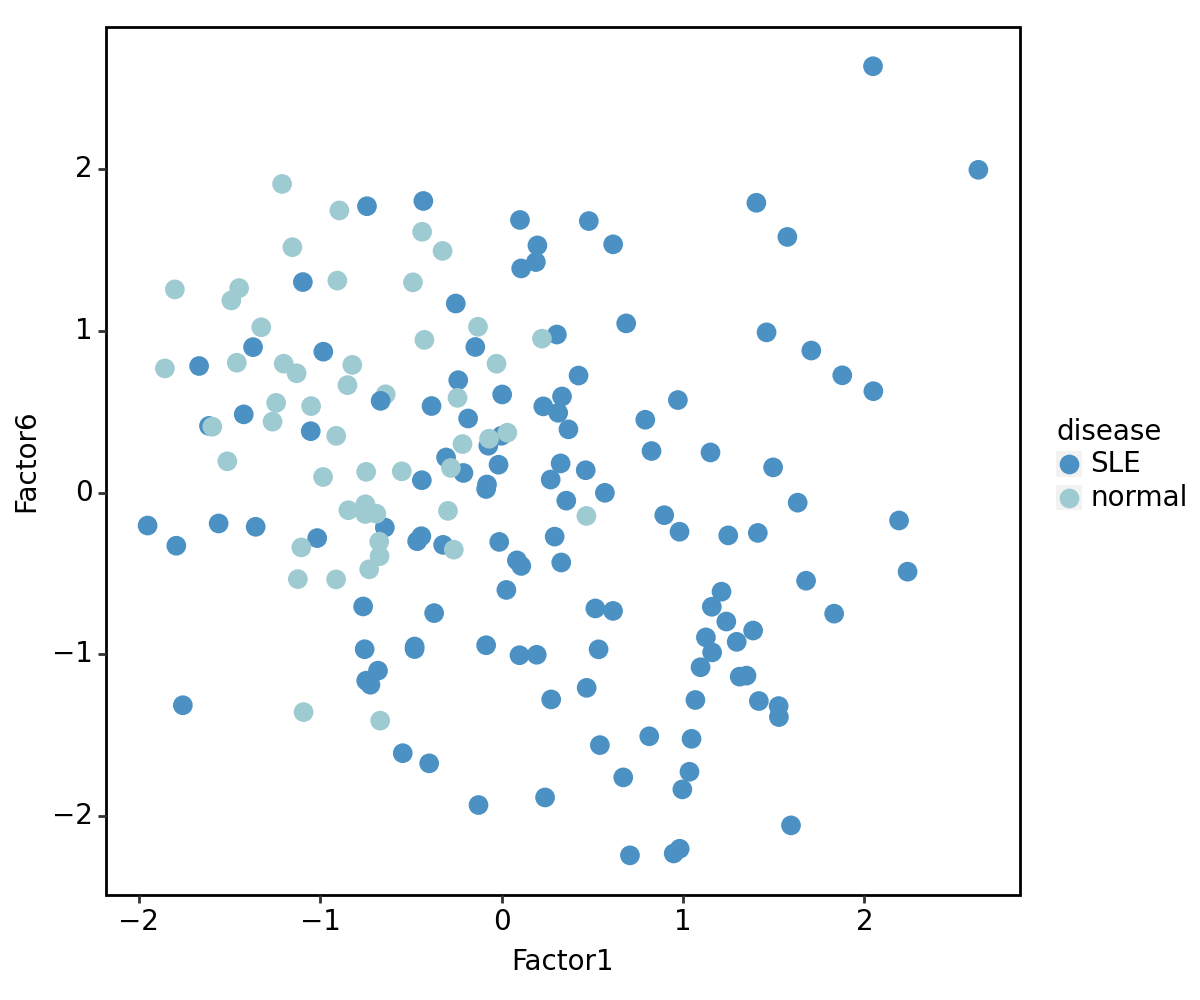

<Figure Size: (600 x 500)>

In [27]:
a1

In [31]:
a1.save('../lupus/figure_lupus/20240103_lupus_umap_factor1_factor6.pdf',bbox_inches = "tight")

In [28]:
factor_matrix_long = factor_matrix.copy()
factor_matrix_long.loc[:,'disease'] =  sample_meta_train.loc[factor_matrix_long.index,:]['disease']
factor_matrix_long.reset_index(inplace=True)
factor_matrix_long = pd.melt(factor_matrix_long, id_vars=['index','disease'], var_name='Factor', value_name='Value')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


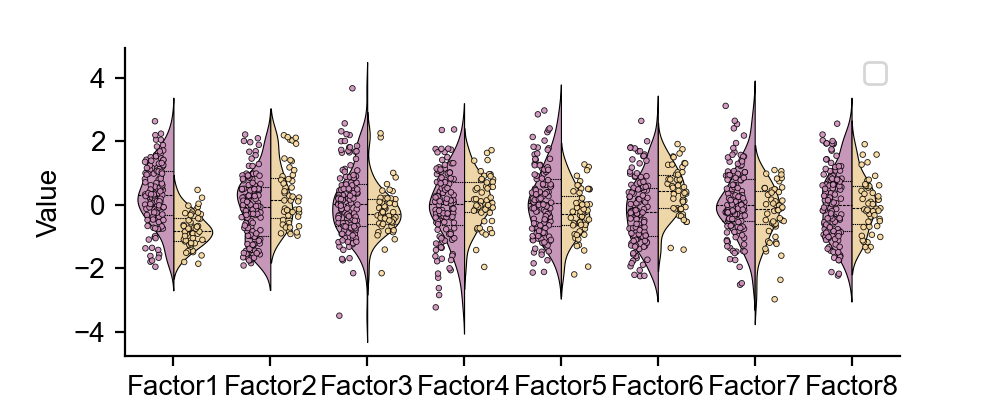

In [36]:
plt.figure(figsize=(5, 2))
sns.violinplot(data=factor_matrix_long, x="Factor", y="Value", hue='disease', split=True, inner="quart",palette=["#cf8fbc","#fad99d"],edgecolor='black',linewidth=0.4,legend=False)
sns.stripplot(data=factor_matrix_long, x="Factor", y="Value", hue="disease", 
              dodge=True, jitter=0.2, alpha=0.9, size=2 ,palette=["#cf8fbc","#fad99d"],edgecolor='black', linewidth=0.3,legend=False)
plt.legend(loc=None) 
sns.despine()
plt.savefig('../lupus/figure_lupus/20241104_lupus_split_violin_disease.pdf',bbox_inches = "tight", transparent=True)
plt.show()

In [39]:
factor_matrix_long = factor_matrix.copy()
factor_matrix_long.loc[:,'batch'] =  sample_meta_train.loc[factor_matrix_long.index,:]['batch']
factor_matrix_long.reset_index(inplace=True)
factor_matrix_long = pd.melt(factor_matrix_long, id_vars=['index','batch'], var_name='Factor', value_name='Value')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


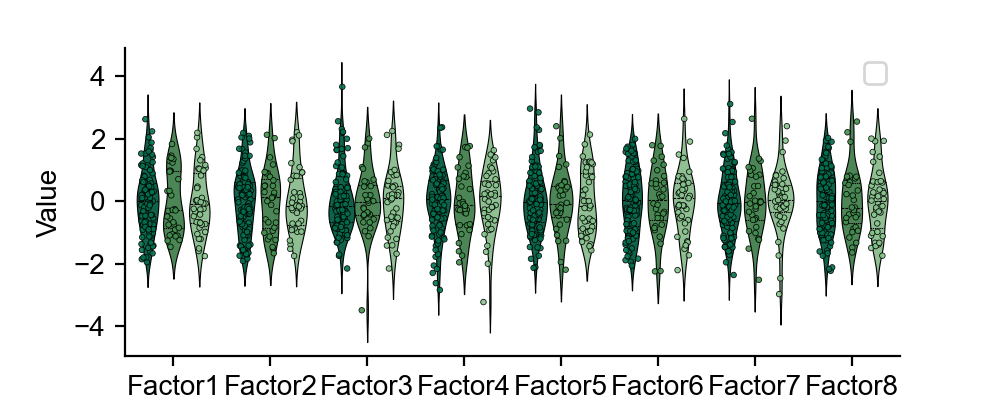

In [46]:
plt.figure(figsize=(5, 2))
sns.violinplot(data=factor_matrix_long, x="Factor", y="Value", hue='batch', split=False, inner="quart",palette=["#027150","#42904f","#88c78e"],edgecolor='black',linewidth=0.4,legend=False)
sns.stripplot(data=factor_matrix_long, x="Factor", y="Value", hue="batch", 
              dodge=True, jitter=0.2, alpha=0.9, size=2 ,palette=["#027150","#42904f","#88c78e"],edgecolor='black', linewidth=0.3,legend=False)
plt.legend(loc=None) 
sns.despine()
plt.savefig('../lupus/figure_lupus/20241104_lupus_split_violin_batch.pdf',bbox_inches = "tight", transparent=True)
plt.show()

In [36]:
group_test_result = scPAFA.st.nonparametric_test_category(sample_factor_df=factor_matrix,metadata=sample_meta_train,label_column='disease')

In [37]:
group_test_result

,Factor,p_value,p_adj,method
0,Factor1,9.790115e-13,7.832092e-12,Mann-Whitney U test
1,Factor2,2.792702e-02,7.447206e-02,Mann-Whitney U test
2,Factor3,1.272116e-01,1.696155e-01,Mann-Whitney U test
3,Factor4,2.151511e-01,2.458870e-01,Mann-Whitney U test
4,Factor5,5.537424e-02,1.107485e-01,Mann-Whitney U test
5,Factor6,8.657266e-05,3.462907e-04,Mann-Whitney U test
6,Factor7,1.079934e-01,1.696155e-01,Mann-Whitney U test
7,Factor8,8.864223e-01,8.864223e-01,Mann-Whitney U test


In [38]:
cmaps={'disease':'tab20','batch':'Dark2'}

In [39]:
a1 = scPAFA.pl.draw_cluster_heatmap(sample_factor_df=factor_matrix[['Factor1','Factor6']],
                              sample_annotaion_df=pd.DataFrame(sample_meta_train[['batch','disease']]),
                              p_value_dataframe=group_test_result,custom_cmap=cmaps,
                              figsize = (8,8))

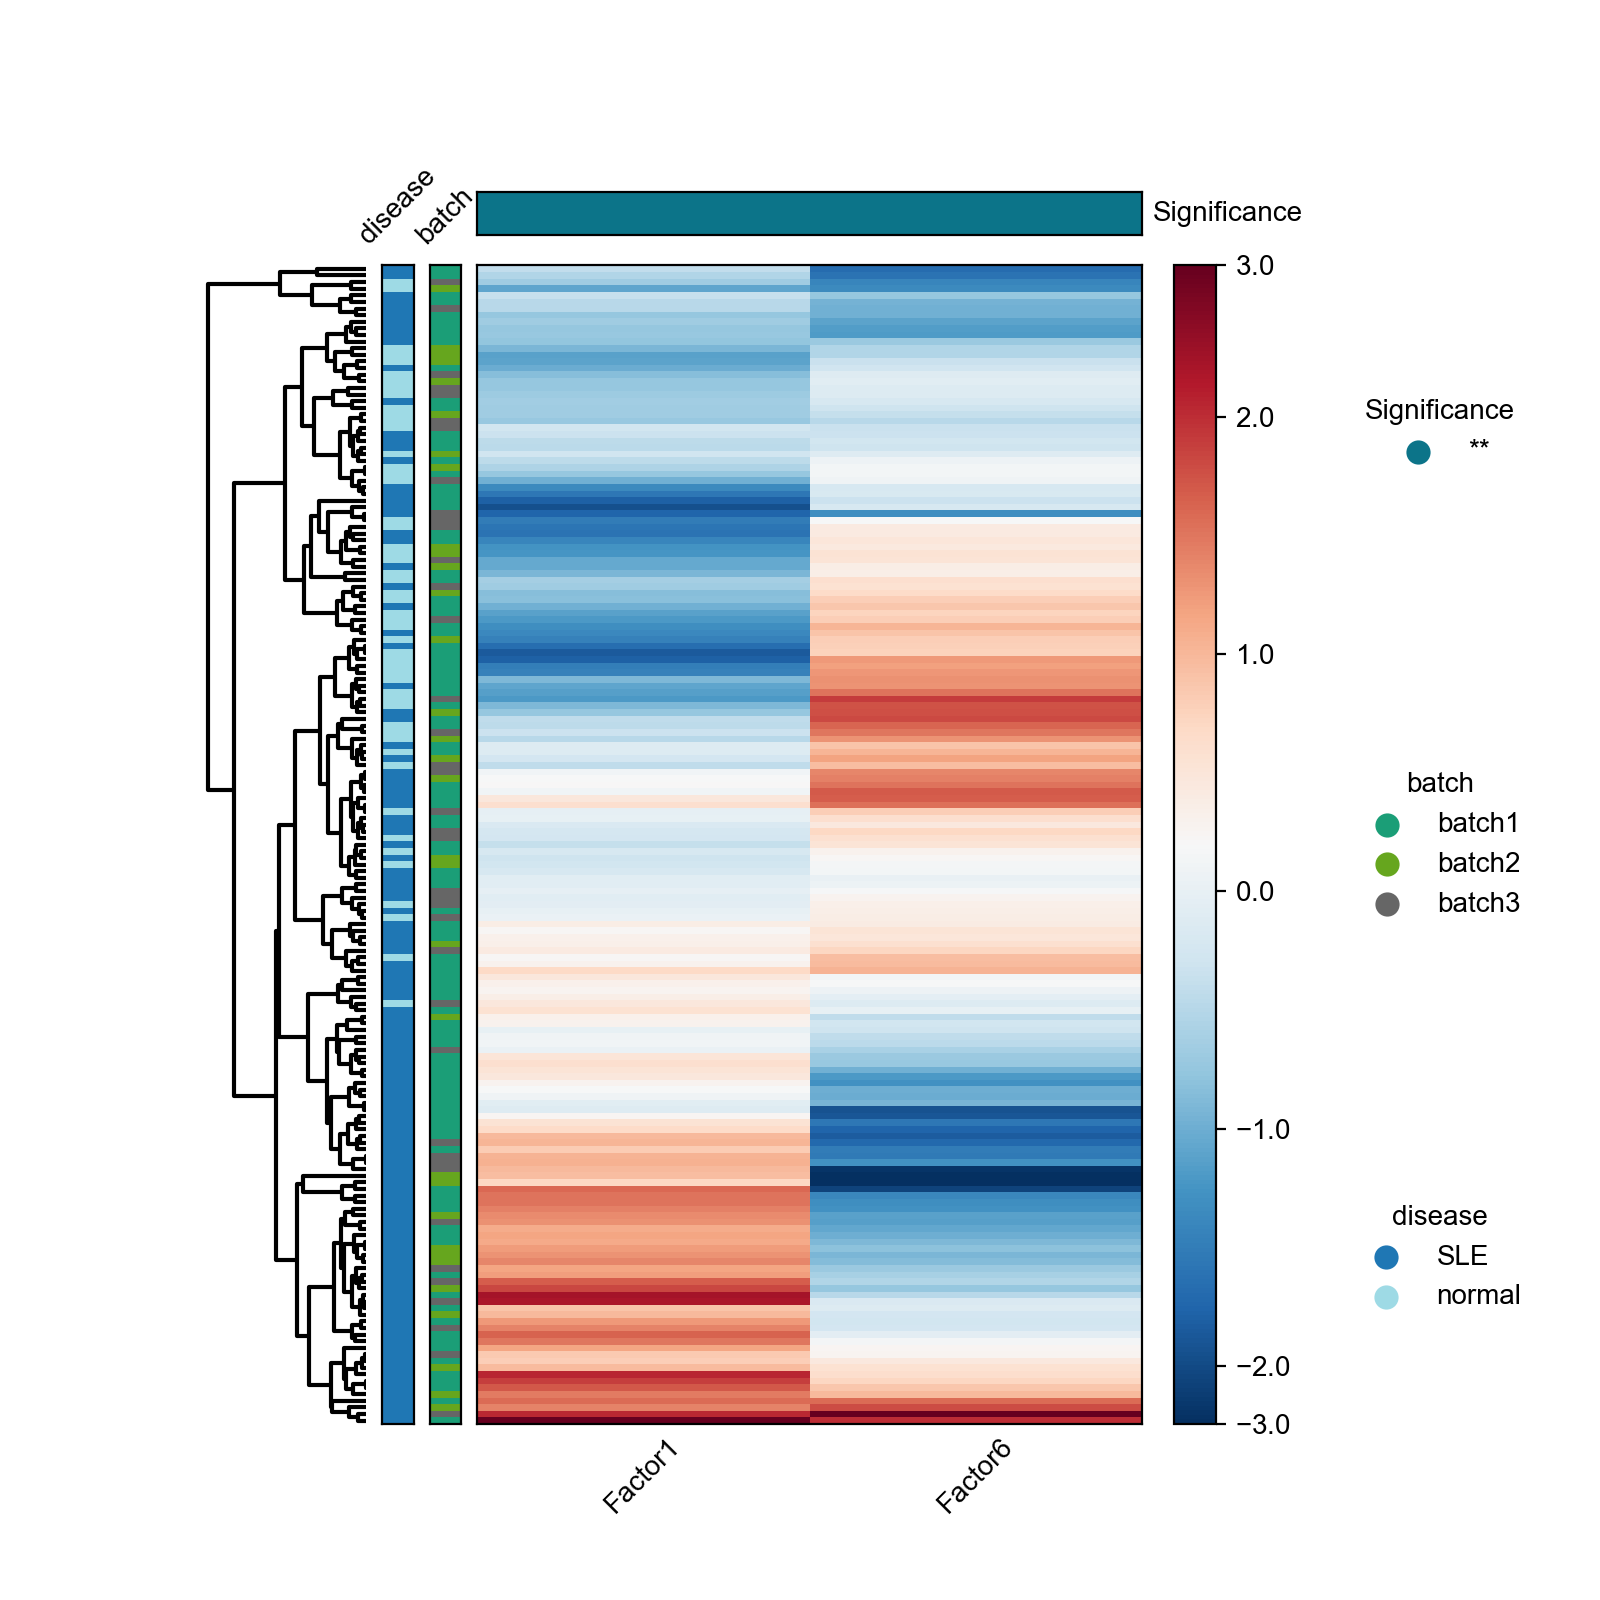

In [40]:
a1.savefig('../lupus/figure_lupus/20240103_lupus_cluster_heatmap_factor1_6.pdf',bbox_inches = "tight")
plt.show()

In [41]:
weight_matrix = pd.concat(MOFA_model.get_weights(concatenate_views =False,scale=True,df =True))

In [4]:
weight_matrix = pd.read_csv('../lupus/20240103_lupus_weight_matrix.csv',index_col=0)

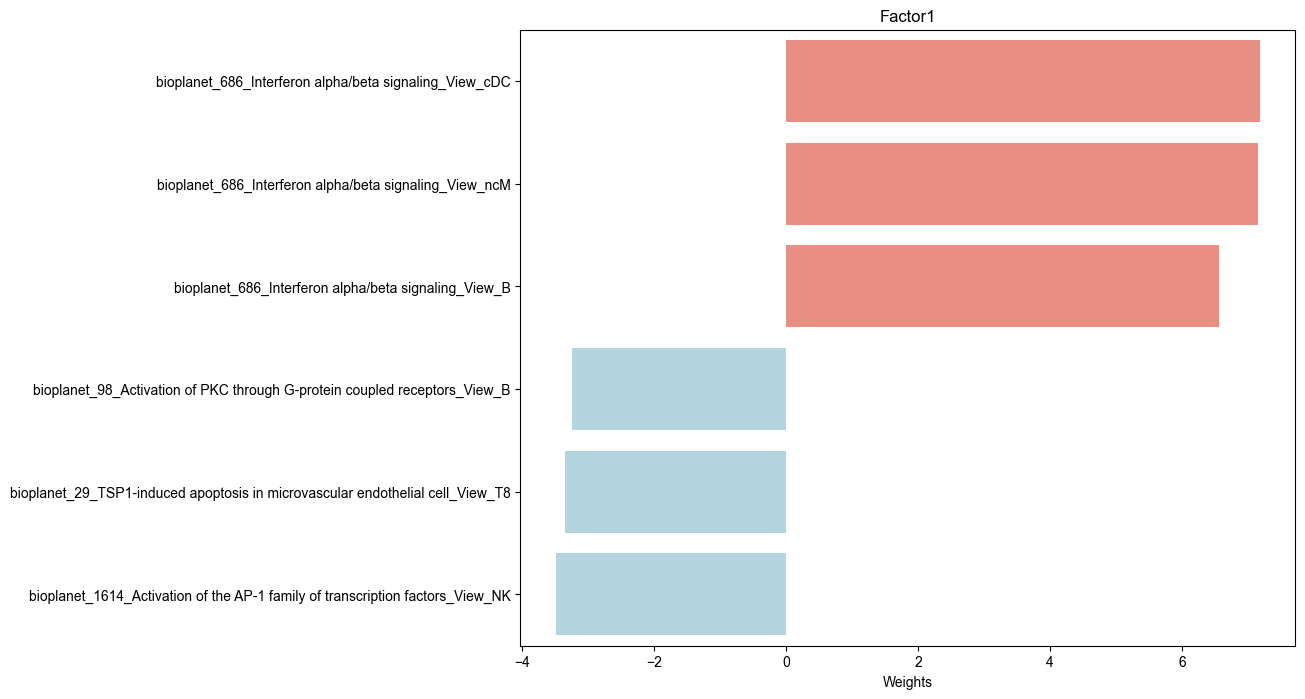

In [8]:
a1 = scPAFA.pl.plot_weights_butterfly(weight_matrix=weight_matrix,factor_name='Factor1',label_beside_bar=False,n_largest=3,n_smallest=3)
a1.savefig('../lupus/figure_lupus/20240103_lupus_cluster_butterfly_factor1.pdf',bbox_inches = "tight")
plt.show()

<module 'matplotlib.pyplot' from '/home/zhuolihuang/.conda/envs/scPAFA_paper/lib/python3.10/site-packages/matplotlib/pyplot.py'>

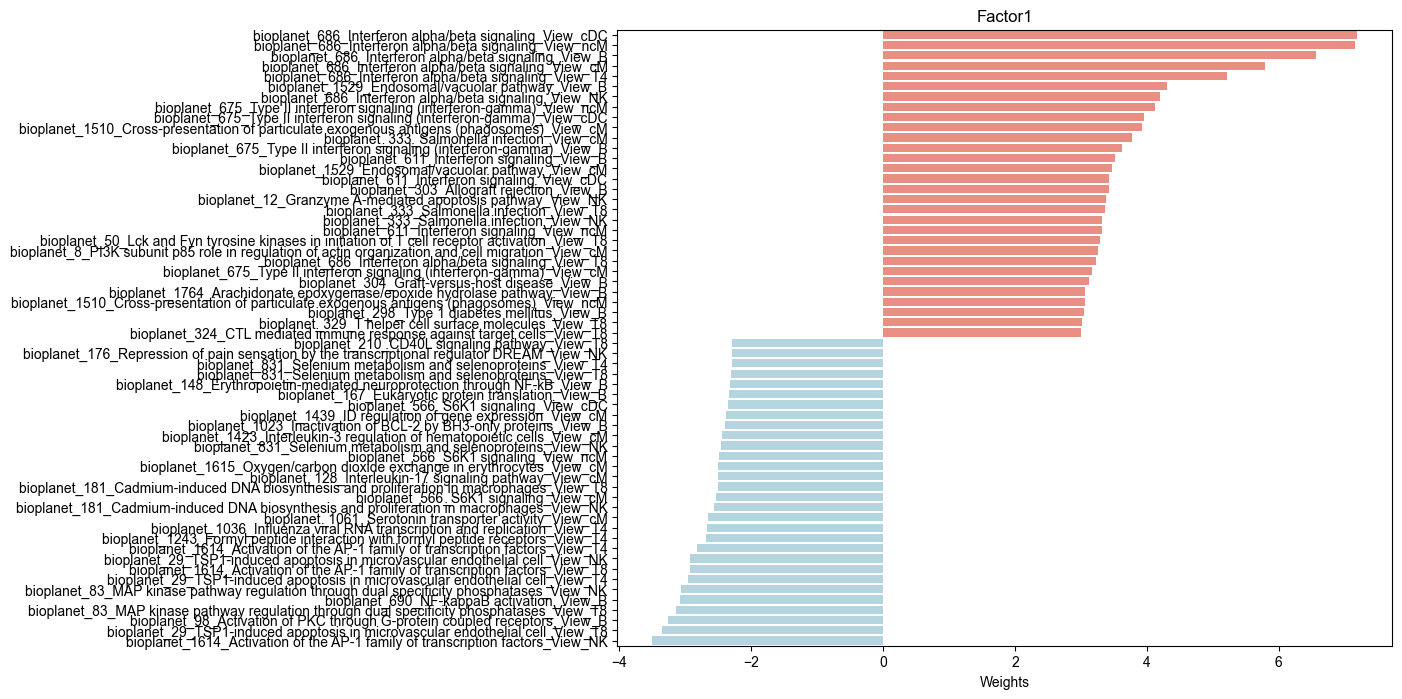

In [5]:
scPAFA.pl.plot_weights_butterfly(weight_matrix=weight_matrix,factor_name='Factor1',label_beside_bar=False,n_largest=30,n_smallest=30)

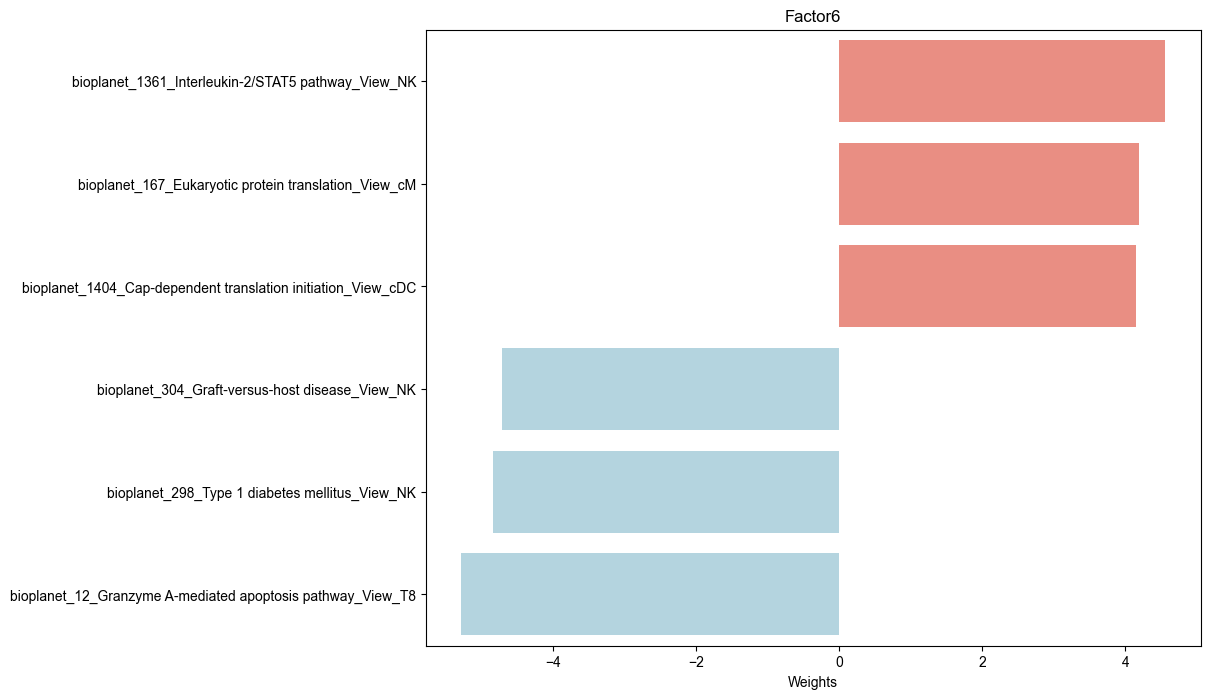

In [7]:
a1 = scPAFA.pl.plot_weights_butterfly(weight_matrix=weight_matrix,factor_name='Factor6',label_beside_bar=False,n_largest=3,n_smallest=3)
a1.savefig('../lupus/figure_lupus/20240103_lupus_cluster_butterfly_factor6.pdf',bbox_inches = "tight")
plt.show()

<module 'matplotlib.pyplot' from '/home/zhuolihuang/.conda/envs/scPAFA_paper/lib/python3.10/site-packages/matplotlib/pyplot.py'>

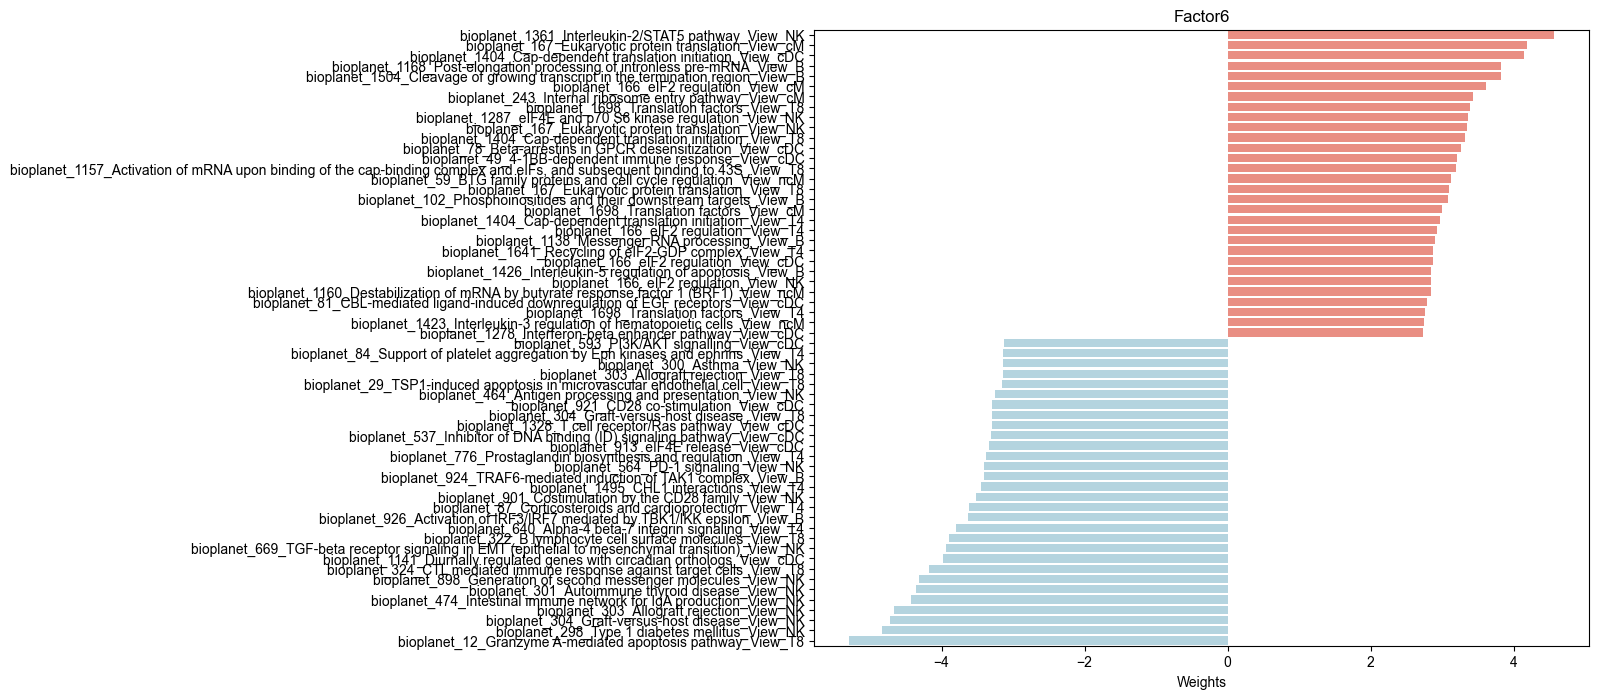

In [6]:
scPAFA.pl.plot_weights_butterfly(weight_matrix=weight_matrix,factor_name='Factor6',label_beside_bar=False,n_largest=30,n_smallest=30)

In [44]:
a1 =mfx.plot_r2(MOFA_model,cmap="Blues")
a1.savefig('../lupus/figure_lupus/20240103_lupus_r2_heatmap.pdf',bbox_inches = "tight")

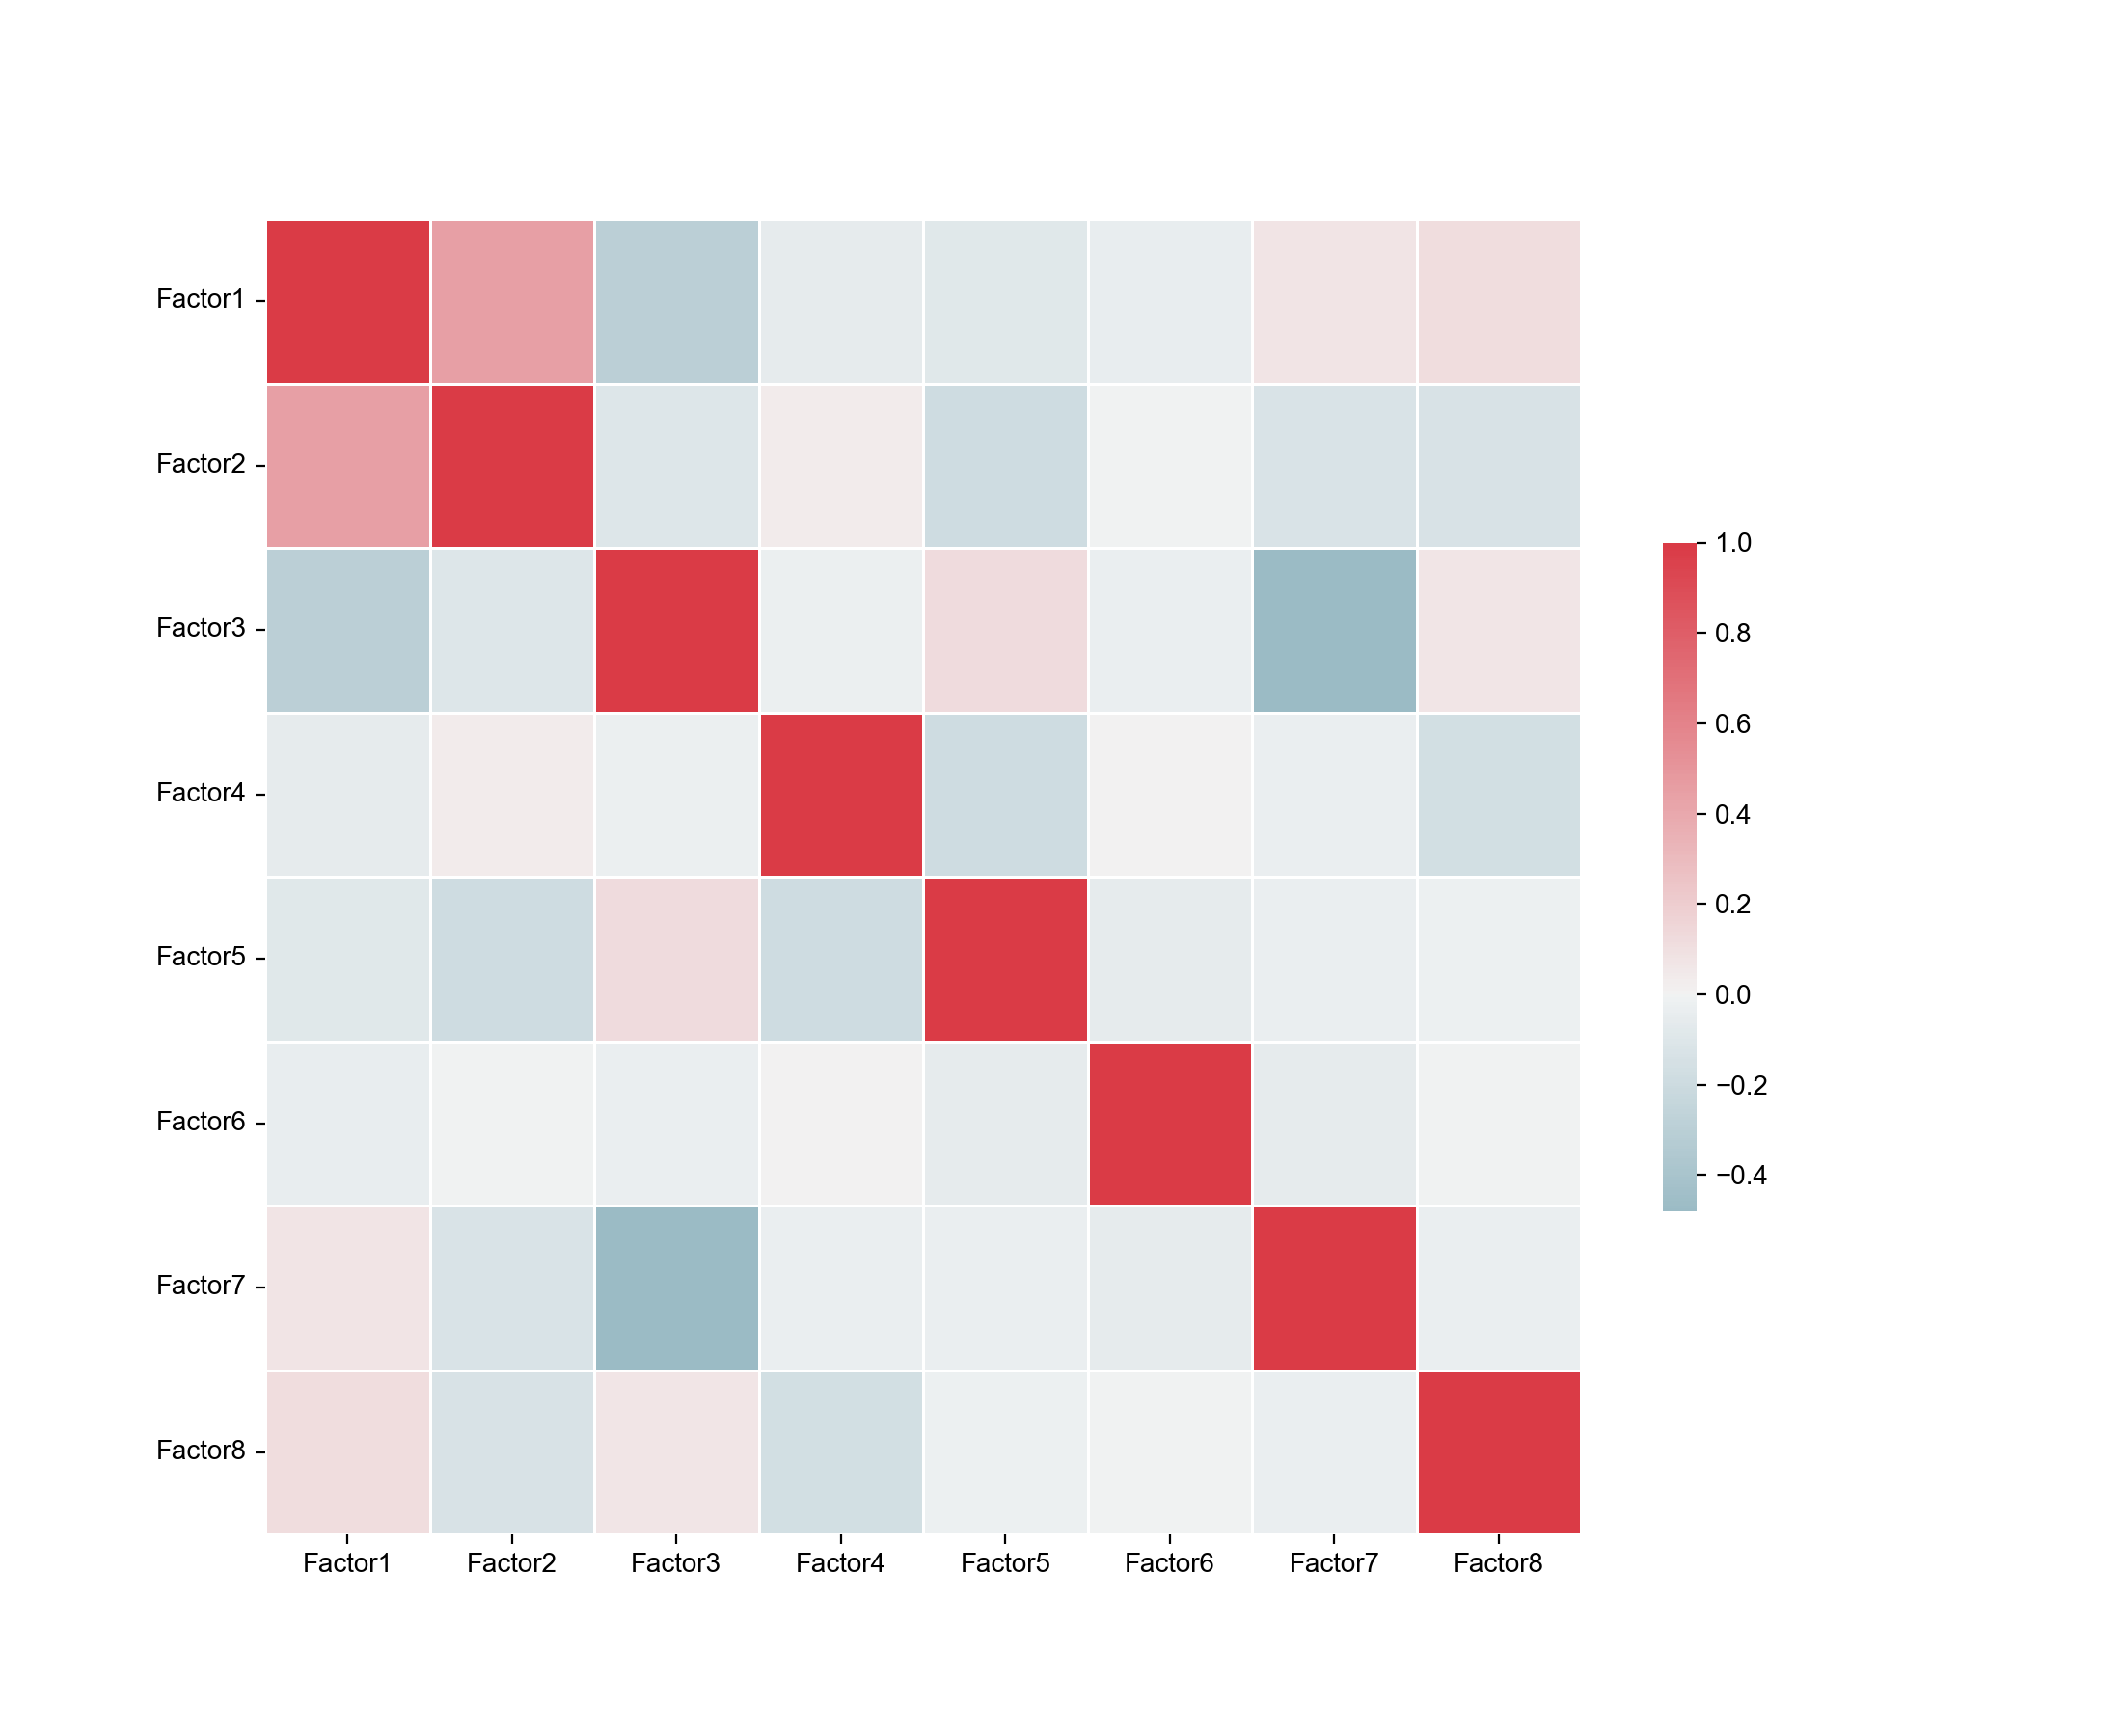

In [45]:
mfx.plot_weights_correlation(MOFA_model)
plt.savefig('../lupus/figure_lupus/20240103_lupus_factor_corr.pdf',bbox_inches = "tight",transparent=True)
plt.show()

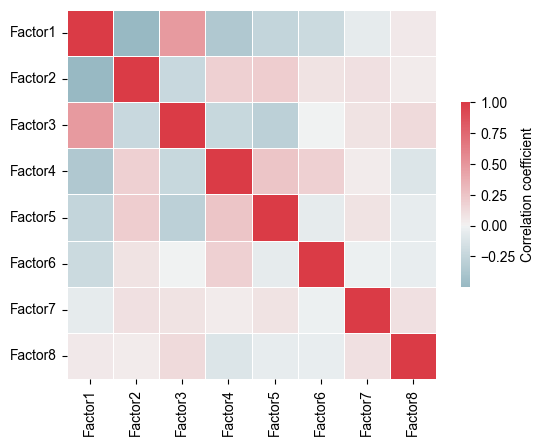

In [5]:
mfx.plot_factors_correlation(MOFA_model)
plt.savefig('../lupus/figure_lupus/20240103_lupus_factor_corr.pdf',bbox_inches = "tight",transparent=True)
plt.show()

In [46]:
weight_matrix.to_csv('../lupus/20240103_lupus_weight_matrix.csv')